# Piecewise linear trends & changepoints
Feature Engineering for Time Series Forecasting

In this notebook we will show how to create features to capture changepoints by building a piecewise linear regression. We will use recursive forecasting to see how we can use this in practice!

We will work with a monthly retail sales dataset (found here).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Create-Datasets" from this repo.

## Data Set Synopsis
The timeseries is between January 1992 and Apr 2005.

It consists of a single series of monthly values representing sales volumes.

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('talk')

In [2]:
data = pd.read_csv('../datasets/example_retail_sales.csv',
                  parse_dates=['ds'],
                  index_col=['ds'])

In [3]:
data.head()

y
ds                
1992-01-01  146376
1992-02-01  147079
1992-03-01  159336
1992-04-01  163669
1992-05-01  170068

## Plot the data

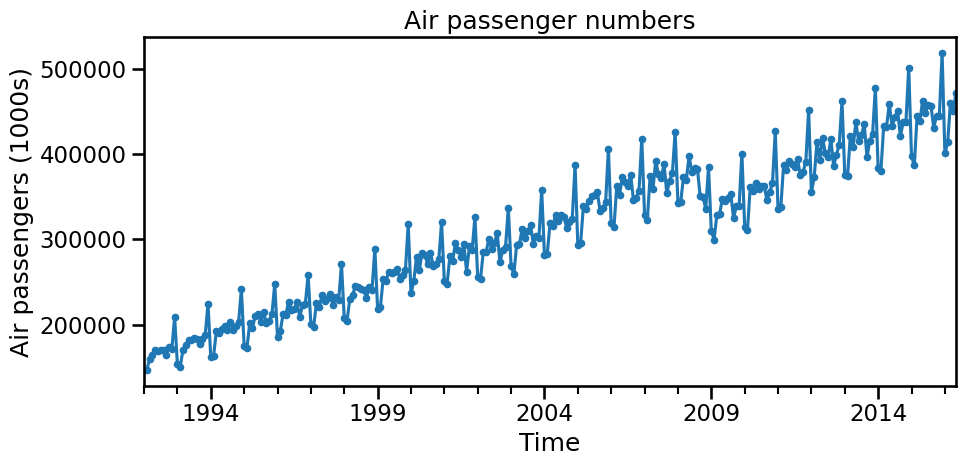

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

data.plot(y='y', marker='.', figsize=(10, 5), legend=None, ax=ax)
ax.set_ylabel('Air passengers (1000s)')
ax.set_xlabel('Time')
ax.set_title('Air passenger numbers')
plt.tight_layout()

## Creating the features with sktime

In [5]:
df = data.copy()

In [6]:
from sktime.transformations.series.time_since import TimeSince

In [7]:
# Specify changepoints
changepoints = [
    "1992-01-01",  # start of time series
    "2008-01-01",  # changepoint
    "2009-04-01",  # changepoint
]

In [8]:
time_since_transformer = TimeSince(
    start=changepoints,
    positive_only=True,
    keep_original_columns=True
)

df = time_since_transformer.fit_transform(df)

In [9]:
df.head()

y  time_since_1992-01-01 00:00:00  \
ds                                                   
1992-01-01  146376                               0   
1992-02-01  147079                               1   
1992-03-01  159336                               2   
1992-04-01  163669                               3   
1992-05-01  170068                               4   

            time_since_2008-01-01 00:00:00  time_since_2009-04-01 00:00:00  
ds                                                                          
1992-01-01                               0                               0  
1992-02-01                               0                               0  
1992-03-01                               0                               0  
1992-04-01                               0                               0  
1992-05-01                               0                               0

In [10]:
df.loc['2007-10':].head(10)

y  time_since_1992-01-01 00:00:00  \
ds                                                   
2007-10-01  368681                             189   
2007-11-01  377802                             190   
2007-12-01  426077                             191   
2008-01-01  342697                             192   
2008-02-01  343937                             193   
2008-03-01  372923                             194   
2008-04-01  368923                             195   
2008-05-01  397969                             196   
2008-06-01  378490                             197   
2008-07-01  383686                             198   

            time_since_2008-01-01 00:00:00  time_since_2009-04-01 00:00:00  
ds                                                                          
2007-10-01                               0                               0  
2007-11-01                               0                               0  
2007-12-01                               0                               0  
2008-01-01                               0                               0  
2008-02-01                               1                               0  
2008-03-01                               2                               0  
2008-04-01                               3                               0  
2008-05-01                               4                               0  
2008-06-01                               5                               0  
2008-07-01                               6                               0

## Let's build a forecast

In [11]:
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

In [12]:
set_config(transform_output="pandas")

In [13]:
df = data.copy()

In [14]:
target = ['y']

In [15]:
# prepare transformers
time_feats = make_pipeline(
    TimeSince(),
    PolynomialFeatures(degree=1, include_bias=False)
)

# compute features for piecewise regression
changepoints = [
    '2008-01-01',
    '2009-04-01'
]

changepoint_feats = TimeSince(changepoints, positive_only=True)

# features computed from the target
lag_window_feats = WindowSummarizer(
    lag_feature={
        'lag': [1],
        # 'mean': [[1, 12]],
    },
    target_cols=target,
    truncate='bfill'
)

In [16]:
# create a pipeline
pipeline = make_union(time_feats, changepoint_feats, lag_window_feats)
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [17]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('timesince',
                                                 TimeSince(positive_only=True, start=['2008-01-01', '2009-04-01'])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1]}, target_cols=['y'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [18]:
pipeline.fit_transform(df)

C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\summarize.py:299: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  func_dict.loc[:, "window"] = func_dict["window"].astype("object")


time_since_1992-01-01 00:00:00  time_since_2008-01-01 00:00:00  \
ds                                                                           
1992-01-01                        0.000000                            0.00   
1992-02-01                        0.003425                            0.00   
1992-03-01                        0.006849                            0.00   
1992-04-01                        0.010274                            0.00   
1992-05-01                        0.013699                            0.00   
...                                    ...                             ...   
2016-01-01                        0.986301                            0.96   
2016-02-01                        0.989726                            0.97   
2016-03-01                        0.993151                            0.98   
2016-04-01                        0.996575                            0.99   
2016-05-01                        1.000000                            1.00   

            time_since_2009-04-01 00:00:00   y_lag_1  
ds                                                    
1992-01-01                        0.000000  0.000000  
1992-02-01                        0.000000  0.000000  
1992-03-01                        0.000000  0.001890  
1992-04-01                        0.000000  0.034850  
1992-05-01                        0.000000  0.046502  
...                                    ...       ...  
2016-01-01                        0.952941  1.000000  
2016-02-01                        0.964706  0.684506  
2016-03-01                        0.976471  0.718458  
2016-04-01                        0.988235  0.843604  
2016-05-01                        1.000000  0.818978  

[293 rows x 4 columns]

In [19]:
# reset the pipeline
pipeline = clone(pipeline)

Build a recursive forecast

In [20]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

In [21]:
# CONFIG
# time of first forecast
forecast_start_time = pd.to_datetime('2013-01-01')

# number of steps to forecast
num_of_forecast_steps = 36

# define the model
model = LinearRegression()

# create a list of periods we'll forecast over
forecast_horizon = pd.date_range(
    start=forecast_start_time,
    periods=num_of_forecast_steps,
    freq='MS'
)

# look back window size
look_back_window_size = pd.DateOffset(months=12)

In [22]:
# CREATE TRAINING AND TESTING DATAFRAME
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

# FEATURE ENGINEERING
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\transformations\series\summarize.py:299: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  func_dict.loc[:, "window"] = func_dict["window"].astype("object")


In [23]:
# MODEL TRAINING
model.fit(X_train, y_train)

LinearRegression()

In [24]:
# CREATE DYNAMIC PREDICTION DATAFRAME
look_back_start_time = forecast_start_time - look_back_window_size

df_predict = df_train.loc[look_back_start_time:].copy()

df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

In [26]:
# RECURSIVE FORECASTING LOOP
for forecast_time in forecast_horizon:
    X_test = pipeline.transform(df_predict)
    X_test_ = X_test.loc[[forecast_time]]

    # predict one step ahead
    y_pred = model.predict(X_test_)

    # append forecast to the target variable column in df_predict
    df_predict.loc[[forecast_time], target] = y_pred

In [27]:
# GET FORECAST AND TEST VALUES
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

In [28]:
# CREATE IN-SAMPLE PREDICTIONS
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Text(0.5, 1.0, 'Forecast with LinearRegression()')

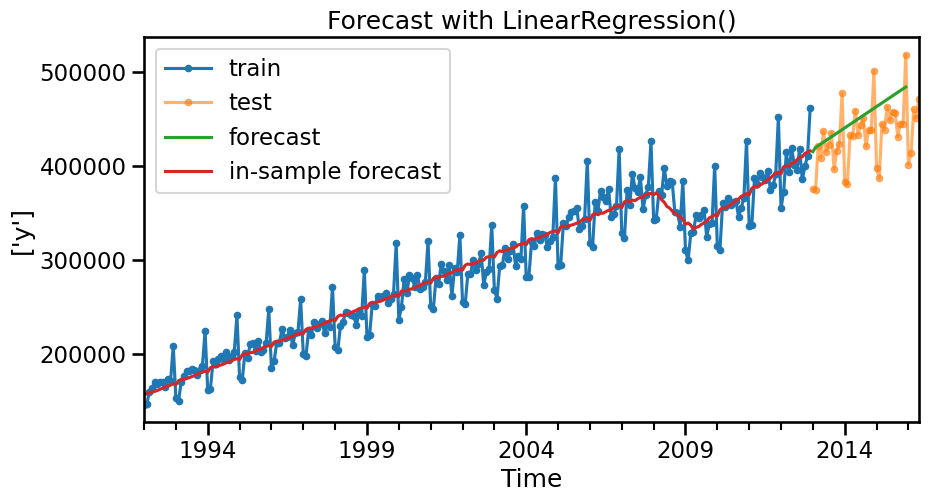

In [29]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])

# Plot training set.
y_train.plot(ax=ax, marker=".")
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker=".", alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

In [30]:
# model coef
pd.Series(index=X_train.columns, data=model.coef_[0])

time_since_1992-01-01 00:00:00    298382.728869
time_since_2008-01-01 00:00:00   -236088.888860
time_since_2009-04-01 00:00:00    211584.046592
y_lag_1                           -16916.362130
dtype: float64

In [31]:
# compute error metrics
from sklearn.metrics import root_mean_squared_error

In [32]:
root_mean_squared_error(y_test.loc[y_forecast.index], y_forecast)

32645.276865803822